In [4]:
from pyltp import Segmentor
segmentor = Segmentor()
segmentor.load("/pi/ai/ltp/ltp_data_v3.4.0/cws.model")
words = segmentor.segment("元芳你怎么看")
print("|".join(words))
segmentor.release()

元芳|你|怎么|看


⊕ [pyltp/example.py at master · HIT-SCIR/pyltp](https://github.com/HIT-SCIR/pyltp/blob/master/example/example.py)


In [7]:
from pyltp import SentenceSplitter, Segmentor, Postagger, Parser, NamedEntityRecognizer, SementicRoleLabeller
import sys, os

MODELDIR='/pi/ai/ltp/ltp_data_v3.4.0'
paragraph = '中国进出口银行与中国银行加强合作。中国进出口银行与中国银行加强合作！'

sentence = SentenceSplitter.split(paragraph)[0]

segmentor = Segmentor()
segmentor.load(os.path.join(MODELDIR, "cws.model"))
words = segmentor.segment(sentence)
print(" ".join(words))

中国 进出口 银行 与 中国银行 加强 合作 。


In [8]:
postagger = Postagger()
postagger.load(os.path.join(MODELDIR, "pos.model"))
postags = postagger.postag(words)
# list-of-string parameter is support in 0.1.5
# postags = postagger.postag(["中国","进出口","银行","与","中国银行","加强","合作"])
print(" ".join(postags))

ns v n p ni v v wp


In [9]:
parser = Parser()
parser.load(os.path.join(MODELDIR, "parser.model"))
arcs = parser.parse(words, postags)

print("\t".join("%d:%s" % (arc.head, arc.relation) for arc in arcs))

3:ATT	3:ATT	6:SBV	6:ADV	4:POB	0:HED	6:VOB	6:WP


In [13]:
recognizer = NamedEntityRecognizer()
recognizer.load(os.path.join(MODELDIR, "ner.model"))
netags = recognizer.recognize(words, postags)
print("\t".join(netags))

B-Ni	I-Ni	E-Ni	O	S-Ni	O	O	O


In [11]:
labeller = SementicRoleLabeller()
labeller.load(os.path.join(MODELDIR, "pisrl.model"))
roles = labeller.label(words, postags, arcs)

for role in roles:
    print(role.index, "".join(
            ["%s:(%d,%d)" % (arg.name, arg.range.start, arg.range.end) for arg in role.arguments]))

5 A0:(0,2)A1:(6,6)


In [12]:
segmentor.release()
postagger.release()
parser.release()
recognizer.release()
labeller.release()


In [14]:
parser = Parser()
parser.load(os.path.join(MODELDIR, "parser.model"))
segmentor = Segmentor()
segmentor.load(os.path.join(MODELDIR, "cws.model"))

paragraph = '中国进出口银行与中国银行加强合作。中国进出口银行与中国银行加强合作！'

sentence = SentenceSplitter.split(paragraph)[0]
words = segmentor.segment(sentence)
print("\t".join(words))

arcs = parser.parse(words, postags)
print("\t".join("%d:%s" % (arc.head, arc.relation) for arc in arcs))

中国	进出口	银行	与	中国银行	加强	合作	。
3:ATT	3:ATT	6:SBV	6:ADV	4:POB	0:HED	6:VOB	6:WP


In [19]:
import sagas
rs=[]
for i in range(len(words)):
    print("%s --> %s|%s|%s|%s" % (words[int(arcs[i].head)-1], words[i], \
        arcs[i].relation, postags[i], netags[i]))
    rs.append((words[int(arcs[i].head)-1], words[i], \
       arcs[i].relation, postags[i], netags[i]))
sagas.to_df(rs, ['弧头','弧尾','依存关系','词性','命名实体'])

银行 --> 中国|ATT|ns|B-Ni
银行 --> 进出口|ATT|v|I-Ni
加强 --> 银行|SBV|n|E-Ni
加强 --> 与|ADV|p|O
与 --> 中国银行|POB|ni|S-Ni
。 --> 加强|HED|v|O
加强 --> 合作|VOB|v|O
加强 --> 。|WP|wp|O


,弧头,弧尾,依存关系,词性,命名实体
0,银行,中国,ATT,ns,B-Ni
1,银行,进出口,ATT,v,I-Ni
2,加强,银行,SBV,n,E-Ni
3,加强,与,ADV,p,O
4,与,中国银行,POB,ni,S-Ni
5,。,加强,HED,v,O
6,加强,合作,VOB,v,O
7,加强,。,WP,wp,O


## 语义角色标注
语义角色标注 (Semantic Role Labeling, SRL) 是一种浅层的语义分析技术，标注句子中某些短语为给定谓词的论元 (语义角色) ，如施事、受事、时间和地点等。其能够对问答系统、信息抽取和机器翻译等应用产生推动作用。 仍然是上面的例子，语义角色标注的结果为下图： ...

其中有三个谓词提出，调研和探索。以探索为例，积极是它的方式（一般用ADV表示），而新机制则是它的受事（一般用A1表示）

核心的语义角色为 A0-5 六种，A0 通常表示动作的施事，A1通常表示动作的影响等，A2-5 根据谓语动词不同会有不同的语义含义。其余的15个语义角色为附加语义角色，如LOC 表示地点，TMP 表示时间等。附加语义角色列表如下：
https://www.ltp-cloud.com/intro#srl_how


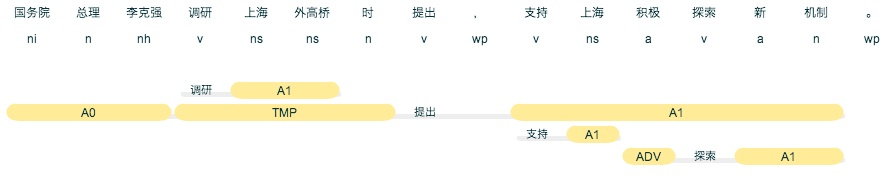

In [21]:
descs='''标记	说明
ADV	adverbial, default tag ( 附加的，默认标记 )
BNE	beneﬁciary ( 受益人 )
CND	condition ( 条件 )
DIR	direction ( 方向 )
DGR	degree ( 程度 )
EXT	extent ( 扩展 )
FRQ	frequency ( 频率 )
LOC	locative ( 地点 )
MNR	manner ( 方式 )
PRP	purpose or reason ( 目的或原因 )
TMP	temporal ( 时间 )
TPC	topic ( 主题 )
CRD	coordinated arguments ( 并列参数 )
PRD	predicate ( 谓语动词 )
PSR	possessor ( 持有者 )
PSE	possessee ( 被持有 )'''
desc_rs=[]
for desc in descs.split('\n')[1:]:
    desc_rs.append(desc.split('\t'))
sagas.to_df(desc_rs, ['mark', 'description'])

,mark,description
0,ADV,"adverbial, default tag ( 附加的，默认标记 )"
1,BNE,beneﬁciary ( 受益人 )
2,CND,condition ( 条件 )
3,DIR,direction ( 方向 )
4,DGR,degree ( 程度 )
5,EXT,extent ( 扩展 )
6,FRQ,frequency ( 频率 )
7,LOC,locative ( 地点 )
8,MNR,manner ( 方式 )
9,PRP,purpose or reason ( 目的或原因 )


In [24]:
labeller = SementicRoleLabeller()
labeller.load(os.path.join(MODELDIR, "pisrl.model"))

In [39]:
def join_words(words, arg_range):
    return ''.join([str(words[idx]) for idx in range(arg_range.start, arg_range.end+1)])

def explain(arg_name):
    if arg_name=='A0':
        return '动作的施事'
    elif arg_name=='A1':
        return '动作的影响'
    return arg_name

print('sents', " ".join(words))
roles = labeller.label(words, postags, arcs)
for role in roles:
    print(role.index, '->', "".join(
            ["%s:(%d,%d) _ " % (arg.name, arg.range.start, arg.range.end) for arg in role.arguments]))
    for arg in role.arguments: 
        # print(''.join(words[arg.range.start:arg.range.end]))
        print(arg.name, arg.range.start, arg.range.end)
        # print(arg.name, words[arg.range.start], words[arg.range.end])
        print(explain(arg.name), join_words(words, arg.range))
        print('----')

sents 中国 进出口 银行 与 中国银行 加强 合作 。
5 -> A0:(0,2) _ A1:(6,6) _ 
A0 0 2
动作的施事 中国进出口银行
----
A1 6 6
动作的影响 合作
----


In [40]:
from termcolor import colored
query="That was very bad"
topk = 5
print('top %d questions similar to "%s"' % (topk, colored(query, 'green')))

top 5 questions similar to "That was very bad"


In [2]:
import sagas
dep_defs='''主谓关系	SBV	subject-verb	我送她一束花 (我 <– 送)
动宾关系	VOB	直接宾语，verb-object	我送她一束花 (送 –> 花)
间宾关系	IOB	间接宾语，indirect-object	我送她一束花 (送 –> 她)
前置宾语	FOB	前置宾语，fronting-object	他什么书都读 (书 <– 读)
兼语	DBL	double	他请我吃饭 (请 –> 我)
定中关系	ATT	attribute	红苹果 (红 <– 苹果)
状中结构	ADV	adverbial	非常美丽 (非常 <– 美丽)
动补结构	CMP	complement	做完了作业 (做 –> 完)
并列关系	COO	coordinate	大山和大海 (大山 –> 大海)
介宾关系	POB	preposition-object	在贸易区内 (在 –> 内)
左附加关系	LAD	left adjunct	大山和大海 (和 <– 大海)
右附加关系	RAD	right adjunct	孩子们 (孩子 –> 们)
独立结构	IS	independent structure	两个单句在结构上彼此独立
核心关系	HED	head	指整个句子的核心'''.split('\n')
def_rs=[]
for dep in dep_defs:
    def_rs.append(dep.split('\t'))
sagas.to_df(def_rs, ['type', 'tag', 'desc', 'example'])

,type,tag,desc,example
0,主谓关系,SBV,subject-verb,我送她一束花 (我 <– 送)
1,动宾关系,VOB,直接宾语，verb-object,我送她一束花 (送 –> 花)
2,间宾关系,IOB,间接宾语，indirect-object,我送她一束花 (送 –> 她)
3,前置宾语,FOB,前置宾语，fronting-object,他什么书都读 (书 <– 读)
4,兼语,DBL,double,他请我吃饭 (请 –> 我)
5,定中关系,ATT,attribute,红苹果 (红 <– 苹果)
6,状中结构,ADV,adverbial,非常美丽 (非常 <– 美丽)
7,动补结构,CMP,complement,做完了作业 (做 –> 完)
8,并列关系,COO,coordinate,大山和大海 (大山 –> 大海)
9,介宾关系,POB,preposition-object,在贸易区内 (在 –> 内)


In [28]:
# https://ltp.readthedocs.io/zh_CN/latest/appendix.html#id3
# LTP 使用的是863词性标注集，其各个词性含义如下表
pos_defs='''a	adjective	美丽	ni	organization name	保险公司
b	other noun-modifier	大型, 西式	nl	location noun	城郊
c	conjunction	和, 虽然	ns	geographical name	北京
d	adverb	很	nt	temporal noun	近日, 明代
e	exclamation	哎	nz	other proper noun	诺贝尔奖
g	morpheme	茨, 甥	o	onomatopoeia	哗啦
h	prefix	阿, 伪	p	preposition	在, 把
i	idiom	百花齐放	q	quantity	个
j	abbreviation	公检法	r	pronoun	我们
k	suffix	界, 率	u	auxiliary	的, 地
m	number	一, 第一	v	verb	跑, 学习
n	general noun	苹果	wp	punctuation	，。！
nd	direction noun	右侧	ws	foreign words	CPU
nh	person name	杜甫, 汤姆	x	non-lexeme	萄, 翱
 	 	 	z	descriptive words	瑟瑟，匆匆'''.split('\n')
pos_rs=[]
for pos in pos_defs:
    parts=pos.split('\t')    
    pos_rs.append(parts[:3])
    pos_rs.append(parts[3:])
sagas.to_df(pos_rs, ['tag','desc','example'])

,tag,desc,example
0,a,adjective,美丽
1,ni,organization name,保险公司
2,b,other noun-modifier,"大型, 西式"
3,nl,location noun,城郊
4,c,conjunction,"和, 虽然"
5,ns,geographical name,北京
6,d,adverb,很
7,nt,temporal noun,"近日, 明代"
8,e,exclamation,哎
9,nz,other proper noun,诺贝尔奖


In [4]:
from sagas.zh.ltp_procs import LtpProcs
ltp=LtpProcs()

In [20]:
def in_filters(val, filters):
    for f in filters:
        # if val.endswith(f):
        # support suffix, also support as 'nsubj:pass'
        if f in val:
            return True
    return False
def parse_sentence(sentence, filters):
    words = ltp.segmentor.segment(sentence)
    postags = ltp.postagger.postag(words)
    arcs = ltp.parser.parse(words, postags)
    roles = ltp.labeller.label(words, postags, arcs)
    netags = ltp.recognizer.recognize(words, postags)
    
    root=''
    root_idx=0
    collector=[]
    verbs=[]
    for i in range(len(words)):
        rel=arcs[i].relation
        pos=postags[i]
        if rel=='HED':
            root=words[i]
            root_idx=i
        if pos=='v':
            verbs.append(words[i])

    print('root', root, root_idx)
    
    rs = []
    for i in range(len(words)):
        print("%s --> %s|%s|%s|%s" % (words[int(arcs[i].head) - 1], words[i], \
                                      arcs[i].relation, postags[i], netags[i]))
        pos=postags[i]
        dep_idx=int(arcs[i].head) - 1
        head=words[dep_idx]
        rel=arcs[i].relation
        rs.append((head, words[i], \
                   rel, pos, netags[i]))
        if dep_idx==root_idx:
            collector.append((rel.lower(), words[i]))
    df=sagas.to_df(rs, ['弧头', '弧尾', '依存关系', '词性', '命名实体'])
    return df, collector, verbs

df, collector, verbs=parse_sentence('我是一个好老师', ['SBV', 'OB'])
print(collector, verbs)
df

root 是 1
是 --> 我|SBV|r|O
老师 --> 是|HED|v|O
老师 --> 一个|ATT|m|O
老师 --> 好|ATT|a|O
是 --> 老师|VOB|n|O
[('sbv', '我'), ('vob', '老师')] ['是']


,弧头,弧尾,依存关系,词性,命名实体
0,是,我,SBV,r,O
1,老师,是,HED,v,O
2,老师,一个,ATT,m,O
3,老师,好,ATT,a,O
4,是,老师,VOB,n,O


In [22]:
def proc(sents):
    import requests
    data = {'lang':'zh', "sents":sents}
    response = requests.post('http://localhost:8091/digest', json=data)
    print(response.status_code, response.json())

proc("我是一个好老师")

200 {'lang': 'zh', 'root': '是', 'sbv': '我', 'vob': '老师', 'verbs': ['是']}


In [23]:
proc('你是如何获得语言的？')

200 {'lang': 'zh', 'root': '是', 'sbv': '你', 'vob': '获得', 'verbs': ['是', '获得']}


In [24]:
proc('你如何获得语言？')

200 {'lang': 'zh', 'root': '获得', 'sbv': '你', 'vob': '语言', 'verbs': ['获得']}


In [25]:
proc('你如何获得语言的？')

200 {'lang': 'zh', 'root': '获得', 'sbv': '你', 'vob': '语言', 'verbs': ['获得']}


获得 --> 你|SBV|r|O
获得 --> 如何|ADV|r|O
？ --> 获得|HED|v|O
获得 --> 语言|VOB|n|O
获得 --> 的|RAD|u|O
获得 --> ？|WP|wp|O


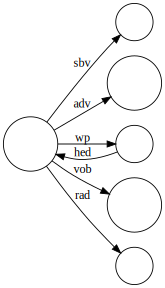

In [33]:
class LtpViz(object):
    def __init__(self, ltp=None):
        from graphviz import Digraph
        from sagas.zh.ltp_procs import LtpProcs
        
        if ltp is None:
            ltp = LtpProcs()
        self.ltp=ltp
        self.f = Digraph('deps', filename='deps.gv')
        self.f.attr(rankdir='LR', size='6,4')
        self.f.attr('node', shape='circle')

    def deps(self, sentence):
        words = self.ltp.segmentor.segment(sentence)
        postags = self.ltp.postagger.postag(words)
        arcs = self.ltp.parser.parse(words, postags)
        roles = self.ltp.labeller.label(words, postags, arcs)
        netags = self.ltp.recognizer.recognize(words, postags)

        for i in range(len(words)):
            a=words[int(arcs[i].head) - 1]
            print("%s --> %s|%s|%s|%s" % (a, words[i], \
                                          arcs[i].relation, postags[i], netags[i]))
            self.f.edge(a, words[i], label=arcs[i].relation.lower())
        return self.f

viz=LtpViz(ltp)
viz.deps('你如何获得语言的？')

送 --> 我|SBV|r|O
花 --> 送|HED|v|O
送 --> 她|IOB|r|O
束 --> 一|ATT|m|O
花 --> 束|ATT|q|O
送 --> 花|VOB|n|O


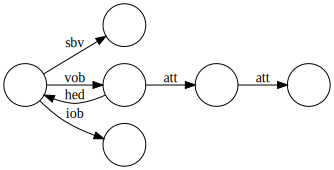

In [37]:
ana=lambda sents: LtpViz(ltp).deps(sents)
ana('我送她一束花')

现有 --> 朝鲜语|SBV|nz|O
可用 --> 现有|HED|v|O
个 --> 11172|ATT|m|O
音节 --> 个|ATT|q|O
现有 --> 音节|VOB|n|O
现有 --> 可用|COO|v|O


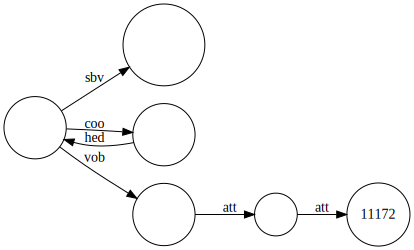

In [38]:
ana('朝鲜语现有11172个音节可用')